# Leadership gap for women scientists in Switzerland

_work-in-progress_

[Joao Martins](https://github.com/zambujo)

In [43]:
import os
import sqlite3

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 6)})

DATA_FOLDER = '../data'
DOCS_FOLDER = '../docs'
IMG_FOLDER = 'img'

In [44]:
# data
conn = sqlite3.connect(os.path.join(DATA_FOLDER, 'p3.db'),
                       detect_types=sqlite3.PARSE_DECLTYPES)
grants = pd.read_sql_query('SELECT * FROM grants;', conn)
grantees = pd.read_sql_query('SELECT * FROM role_in_grants;', conn)
people = pd.read_sql_query('SELECT * FROM people;', conn)

# TODO: move next line to cleaning.ipynb (#13)
grants = grants.dropna(subset=['start_date'])
grants['year'] = grants['start_date'].dt.year

# project leaders + project employees + gender + their projects
df=(grantees
      .query('role in ["employee", "responsible_applicant"]')
      .merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
      .merge(grants, on='project_number'))
# TODO: execute join in SQLite# keep projects with at least one employee and one responsible applicant

# keep projects with at least one employee and one responsible applicant
# remove Careers and Science communication
df_selection = (df
  .query('programme in ["Infrastructure", "Programmes", "Project funding"]')
  .groupby(['project_number', 'role'])
  .size()
  .reset_index(name="n")
  .pivot_table(index="project_number", columns="role", values="n", fill_value=0)
  .query('responsible_applicant > 0')
  .query('employee > 0')
  .reset_index()[['project_number']])

df=df.merge(df_selection, on='project_number')

## The "leaky" pipeline

It is well-known that women are underrepresented in leadership positions.  Science is no exception. The "leaky" pipeline refers to the overly disproportionate loss of women throughout careers in science.

**If science careers are a "leaky" pipeline for women scientists, then the share of women leading science projects is expected to be lower than the share of women employed in science projects.**

---

See also: 
1. [Leaky pipeline for women scientists dries up after they win first big grant](https://www.nature.com/articles/d41586-018-05759-w), _in Nature, 2018_
2. [A Leak in the Academic Pipeline](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.01297/full), _in Frontiers, 2019_

## Looking for evidence

The Swiss National Science Foundation, the leading public science funding agency in Switzerland, makes its data freely available with:  
 - over 70k science projects, spanning across 50 years  
 - over 100k scientists  
 - function and gender of each scientist
 
Source: [p3.snf.ch](http://p3.snf.ch/Pages/DataAndDocumentation.aspx)

In [48]:
# counts by year between 2000 and 2019
counts = (df
            .query('(year > 1999) & (year < 2020)')
            .groupby(['year', 'role', 'gender']).size()
            .reset_index().rename(columns={0:'count'}))
counts = counts.pivot_table(index=['year', 'role'], columns='gender', values='count', fill_value=0)
counts['both'] = (counts['male'] + counts['female'])
counts['percent_women'] = 100 * counts['female'] / counts['both']
counts['percent_men'] = 100 * counts['male'] / counts['both']

In [49]:
counts.query('role=="employee"')

,gender,female,male,both,percent_women,percent_men
year,role,,,,,
2000,employee,1208,2006,3214,37.585563,62.414437
2001,employee,955,1598,2553,37.406972,62.593028
2002,employee,979,1588,2567,38.137904,61.862096
2003,employee,1079,1644,2723,39.625413,60.374587
2004,employee,1072,1591,2663,40.255351,59.744649
2005,employee,1159,1745,2904,39.910468,60.089532
2006,employee,1228,1712,2940,41.768707,58.231293
2007,employee,1378,1747,3125,44.096000,55.904000
2008,employee,1272,1690,2962,42.943957,57.056043


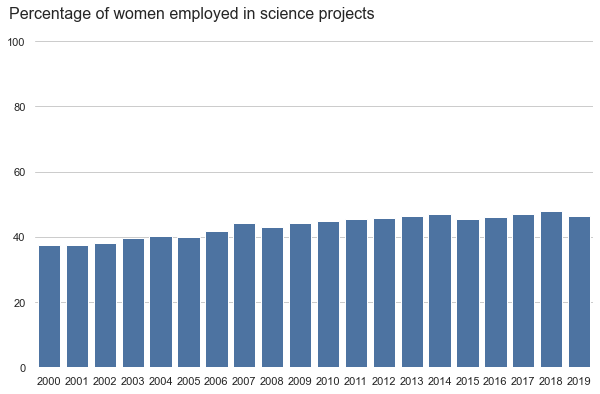

In [50]:
sns.set_style("whitegrid")
plt.box(on=None)
g=sns.barplot(x='year', y='percent_women', color='#3f72af', data=counts.query('role == "employee"').reset_index())
g.set_xlabel('')
g.set_ylabel('')
g.set(ylim=(0, 100))
g.set_title('Percentage of women employed in science projects', fontsize = 16, x=.28, y=1.05)
fig = g.get_figure()
fig.savefig(os.path.join(DOCS_FOLDER, IMG_FOLDER, 'plot1.svg'))

## Share of women employed in science projects

The share of women employed in science projects raised from 38% in 2000 to 46% in 2019.

![plot 1](./img/plot1.svg "Percentage of women employed in science projects")

In [51]:
counts.query('role=="responsible_applicant"')

,gender,female,male,both,percent_women,percent_men
year,role,,,,,
2000,responsible_applicant,118,852,970,12.164948,87.835052
2001,responsible_applicant,115,719,834,13.788969,86.211031
2002,responsible_applicant,89,691,780,11.410256,88.589744
2003,responsible_applicant,121,728,849,14.252061,85.747939
2004,responsible_applicant,131,793,924,14.177489,85.822511
2005,responsible_applicant,106,854,960,11.041667,88.958333
2006,responsible_applicant,178,864,1042,17.082534,82.917466
2007,responsible_applicant,158,944,1102,14.337568,85.662432
2008,responsible_applicant,173,931,1104,15.670290,84.329710


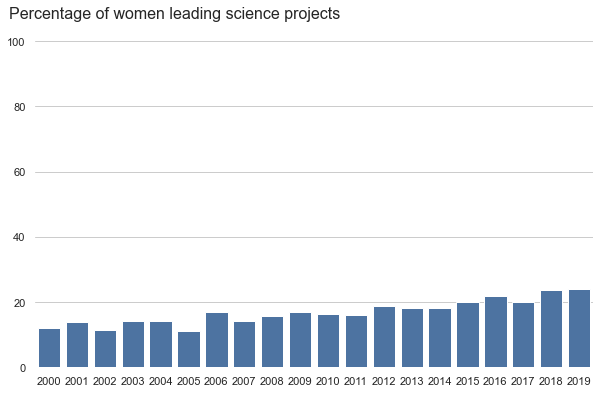

In [52]:
plt.box(on=None)
sns.set_style("whitegrid")
g=sns.barplot(x='year', y='percent_women', color='#3f72af', data=counts.query('role == "responsible_applicant"').reset_index())
g.set_xlabel('')
g.set_ylabel('')
g.set(ylim=(0, 100))
g.set_title('Percentage of women leading science projects', fontsize = 16, x=.25, y=1.05)
fig = g.get_figure()
fig.savefig(os.path.join(DOCS_FOLDER, IMG_FOLDER, 'plot2.svg'))

## Share of women leading science projects

The share of women leading science projects raised from 15% in 2000 to 33% in 2019.

![plot 2](./img/plot2.svg "Percentage of women leading science projects")

In [53]:
gap_women = counts.pivot_table(index=['year'], columns='role', values='percent_women', fill_value=0)
gap_women['ratio'] = gap_women['responsible_applicant'] / gap_women['employee']
gap_men = counts.pivot_table(index=['year'], columns='role', values='percent_men', fill_value=0)
gap_men['ratio'] = gap_men['responsible_applicant'] / gap_men['employee']
gap = pd.concat([gap_women, gap_men], keys=['women', 'men'])
gap = gap.reset_index().rename(columns={'level_0':'gender'})

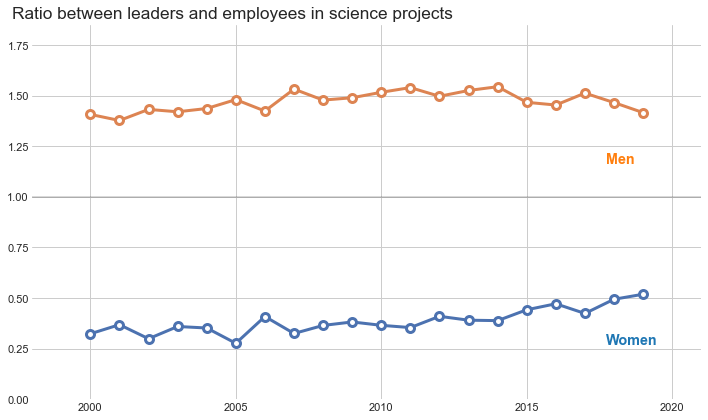

In [57]:
# custom lineplot with matplotlib
mpl.rcParams['lines.linewidth']=3
plt.rcParams['figure.figsize']=(10, 6)
plt.gcf().set_size_inches(10, 6)
plt.style.use('seaborn-whitegrid')
plt.plot(gap.query('gender=="women"').year, 
         gap.query('gender=="women"').ratio,
         '-o',
         markersize=8,
         markerfacecolor='white',
         markeredgewidth=3)
plt.plot(gap.query('gender=="men"').year, 
         gap.query('gender=="men"').ratio,
         '-o',
         markersize=8,
         markerfacecolor='white',
         markeredgewidth=3)
plt.figtext(.85, .18, 
            u'Women', ha='left', va='bottom', 
            color='#1f77b4', fontsize='large', fontweight='semibold')
plt.figtext(.85, .6, 
            u'Men', ha='left', va='bottom', 
            color='#ff7f0e', fontsize='large', fontweight='semibold')
plt.axhline(y=1, color='black', linestyle='-', linewidth=2, alpha=.15)
plt.xlim(1998, 2021)
plt.ylim(0, 1.85)
plt.title('Ratio between leaders and employees in science projects', fontsize='x-large', fontweight='light', x = .3)
plt.box(on=None)
plt.tight_layout()
plt.savefig(os.path.join(DOCS_FOLDER, IMG_FOLDER, 'plot3.svg'))

## Leadership gap between men and women

The leadership gap between men and women appears to be steadily closing.

![plot 3](./img/plot3.svg "Ratio bewteen people leading and employed in science projects")

## Next steps

Next steps:
 - domain-by-domain figures  

---

Further reading:  
- [Promotion of women by the SNSF](http://www.snf.ch/en/researchinFocus/newsroom/Pages/news-181004-promotion-of-women-by-the-snsf.aspx)  
- [Fix the leaky pipeline](https://www.fix-the-leaky-pipeline.ch)
